In [1]:
import numpy as np
import scipy.fftpack
import netCDF4 as netcdf
import matplotlib.pyplot as plt
from IPython.display import display,clear_output
import xarray as xr
import os

g = 9.80665 # gravitation constant

## Set model configuration parameters

In [2]:
# Remember for python, so array index goes from 0 to nx-1 in x-direction

## Specify the grid:
Select a grid size that allows the Poisson solver to be fast.

2<sup>n</sup> +1 for `nx` and `nz` is ideal.

In [3]:
nx = 65 # number of grid points in horizontal
nz = 65 # number of grid points in vertical

lenx = 2560 # grid length in meters
lenz = 2560 # grid height in meters

# Calculate grid spacing dx, dz; Note: subtract number of points by 1 to account for endpoints.

dx = lenx/(nx - 1.)
dz = lenz/(nz - 1.)

print( 'Grid spacings in x and z directions: ', dx, dz)

tstop = 1000.0 # seconds

dt = 4.0 # time step size in seconds

Courant =  dt/dx * 10.0 # Courant number assiming max wind speed of 10 m/s. Should not exceed 1.

print( "Courant number = {0:10.3f}".format(Courant) )

numt = int( tstop/dt ) + 1 # number of times to advance time t

theta0 = 300.

thermradx = 0.2*lenx # Initial thermal bubble horizontal radius in m
thermradz = 0.2*lenz # Initial thermal bubble vertical radius in m

# Remember: python indicies start at 0
thermx = 0.5*lenx # Initial horizontal position of thermal bubble 
thermz = 0.5*lenz # Initial vertical position of thermal bubble

delpt = 5. # Thermal bubble perturbation

Grid spacings in x and z directions:  40.0 40.0
Courant number =      1.000


## Calculate 2-d advection of general variable b
## m1 and p1 refer to minus and plus one respectively

## Also explicitly calculate x, z, and t arrays

In [4]:
x_grid = np.arange(0,nx,1)*dx
z_grid = np.arange(0,nz,1)*dz
t_grid = np.arange(0,numt,1)*dt

# Initalize state variable arrays to zero
u = np.zeros((numt,nz,nx))
w = np.zeros((numt,nz,nx))
theta = np.zeros((numt,nz,nx)) # Note theta here is perturbations per governing equations

u[:,:,:] = -10.0
w[:,:,:] = 0.0

umax = np.max( np.abs(u[0,:,:]) )
Courant = dt/dx * umax # Courant number assiming max wind speed of 10 m/s. Should not exceed 1.
print( "1D Courant number in x = {0:10.3f}".format(Courant) )

# Initial thermal perturbation 
for i in np.arange(1,nx-1):
    for k in np.arange(1,nz-1):
        radnd = np.sqrt(((i*dx-thermx)/thermradx)**2.+((k*dx-thermz)/thermradz)**2.)
        if(radnd < 1.):
            theta[0,k,i] = theta[0,k,i] + delpt*(np.cos(radnd*np.pi/2.)**2.)

1D Courant number in x =      1.000


In [5]:
def cal_advect_2d(u,w,bim1,bip1,bkm1,bkp1,b,dx,dz):

    adv = -0.5*( ((u+np.absolute(u))*(b-bim1)+(u-np.absolute(u))*(bip1-b))/dx \
                +((w+np.absolute(w))*(b-bkm1)+(w-np.absolute(w))*(bkp1-b))/dz )
    
    return adv

In [6]:
# main time loop, horizontal loop, vertical loop
# note that boundary points remain zero to satisfy boundary conditions
for t in np.arange(0, numt-1, 1):

    for i in np.arange(1, nx-1, 1):
        for k in np.arange(1, nz-1, 1):
             theta[t+1,k,i] = theta[t,k,i] - dt/dx * u[t, k,i ]*( theta[ t,k,i+1] - theta[t,k,i]   )# complete this line
#
# write alternative form of code that uses np.absolute(u) without if condition  
#
#           theta[t+1,k,i] = theta[t,k,i] - ...   # complete this line
#
#
    time = (t+1) *  dt
    
# set periodic boundary condition for theta in x direction

    theta[t+1,:,0] = theta[t+1,:,nx-2]
    theta[t+1,:,nx-1] = theta[t+1,:,1]
    
    ptmax = np.max( theta[t+1,:,:] )
    ptmin = np.min( theta[t+1,:,:] )

    print("ptmin,ptmax at time {0:6.0f} (s) are: {1:6.2f} {2:6.2f} ".format(time,ptmin,ptmax) )

ptmin,ptmax at time      4 (s) are:   0.00   5.00 
ptmin,ptmax at time      8 (s) are:   0.00   5.00 
ptmin,ptmax at time     12 (s) are:   0.00   5.00 
ptmin,ptmax at time     16 (s) are:   0.00   5.00 
ptmin,ptmax at time     20 (s) are:   0.00   5.00 
ptmin,ptmax at time     24 (s) are:   0.00   5.00 
ptmin,ptmax at time     28 (s) are:   0.00   5.00 
ptmin,ptmax at time     32 (s) are:   0.00   5.00 
ptmin,ptmax at time     36 (s) are:   0.00   5.00 
ptmin,ptmax at time     40 (s) are:   0.00   5.00 
ptmin,ptmax at time     44 (s) are:   0.00   5.00 
ptmin,ptmax at time     48 (s) are:   0.00   5.00 
ptmin,ptmax at time     52 (s) are:   0.00   5.00 
ptmin,ptmax at time     56 (s) are:   0.00   5.00 
ptmin,ptmax at time     60 (s) are:   0.00   5.00 
ptmin,ptmax at time     64 (s) are:   0.00   5.00 
ptmin,ptmax at time     68 (s) are:   0.00   5.00 
ptmin,ptmax at time     72 (s) are:   0.00   5.00 
ptmin,ptmax at time     76 (s) are:   0.00   5.00 
ptmin,ptmax at time     80 (s) 

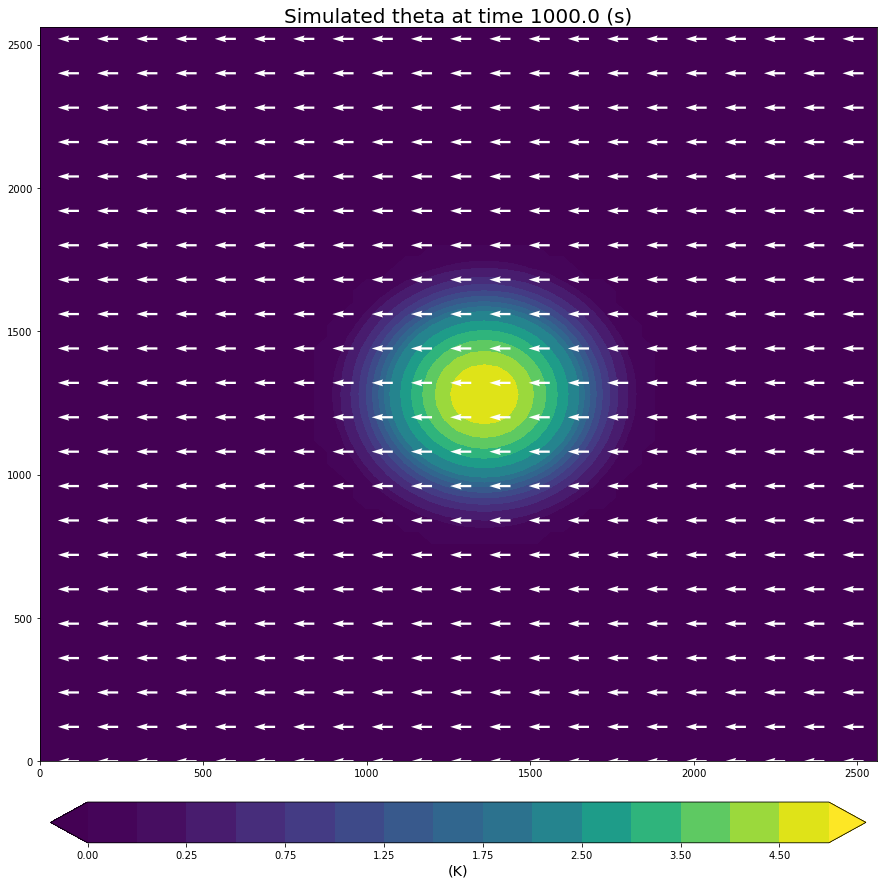

In [7]:
# Make plots
# First construct figure and axes of plot
fig_ex = plt.figure( figsize=(15, 17) )
ax_ex = fig_ex.add_subplot(111)

outdir='Cloud_pngs' 
if outdir and not os.path.exists(outdir): os.mkdir(outdir)

# Time loop to display plots sequentially
for t in np.arange(0,numt,5):
    
    # Clear prior axis data so plots don't stack on top of each other
    ax_ex.clear()
    
    # Note arrays are (row,column...) in python indices. Since i is column and k is
    # row in our model, we need to simply transverse 2-D arrays to align with the 
    # expected plots
    
    # Plot theta
    
#    sfmax = np.max( streamf[t,:,:] )
#    sfmin = np.min( streamf[t,:,:] )
    
    #print("sfmin= {0:6.2f}, sfmax= {1:6.2f} at time {2:6.0f} (s)".format(sfmin, sfmax,t*dt) )
    
    levels = [0.0,0.125,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
#    levels = np.arange(0,3.5,0.5)
    
    theta_plot = ax_ex.contourf(x_grid,z_grid,theta[t,:,:], levels=levels, extend='both')
#    theta_plot = ax_ex.contourf(x_grid,z_grid,theta[t,:,:], extend='both')
    
    # Plot streamfunction (levels are contours, 'w' refers to white contours)
    #streamf_plot = ax_ex.contour(x_grid,z_grid,streamf[t,:,:],\
    #        evels=np.array([-500,-400,-300,-250,-200,-150,-125,-100,-75,-50,-25,\
    #                        25,50,75,100,125,250,200,300,400,500]),colors='red')
    
#    streamf_plot = ax_ex.contour(x_grid,z_grid,streamf[t,:,:],\
#                                 levels=np.arange(-500,550,50),colors='red')
    
    # Plot wind vectors at windintv intervals (python slices arrays as [start:stop:interval])
    windintv = 3 # Plot interval for wind vectors
    vector_plot = ax_ex.quiver(x_grid[::windintv],z_grid[::windintv],\
                               u[t,::windintv,::windintv],w[t,::windintv,::windintv], color='white')
    time = t*dt
    plt.title('Simulated theta at time {0:6.1f} (s)'.format(time),fontsize=20 )
    
    if t == 0:
        cb1 = fig_ex.colorbar(theta_plot, ax=ax_ex, location='bottom', shrink=1.0, fraction=0.05, pad=0.05)
        cb1.set_label('(K)', size='x-large')

    # Display plots
    clear_output(wait=True)
    display(fig_ex)
    
    if outdir: 
        timestamp = round(time,2)
        pngname = outdir+'/cloud%06d.png' % round(timestamp) 
#        print( pngname )
        plt.savefig(pngname, dpi=72, facecolor='w', edgecolor='w', orientation='portrait',bbox_inches = 'tight')
    
clear_output()

In [10]:
from janim import makeanim
import glob

pngs = glob.glob(outdir+'/*.png') # the * matches anything
pngs.sort()
makeanim(pngs,outfile="1DAdvection.html",sortOrder=True,
         ctlOnSide=True,titlestring="Animation of 1D Advection")